In [1]:
# Essential Libraries
import os
import sys
import numpy as np
from numpy import ndarray
import pandas as pd
import random
from typing import Callable, Dict, Tuple, List

# ML
# from sklearn import datasets
# import tensorflow as tf
# import keras

# Plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn-whitegrid')

# Display options
pd.set_option('display.max_columns', None);
pd.options.display.max_seq_items = 8000;
pd.options.display.max_rows = 8000;
%precision 6

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore")

# Define data and image directory
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "img")

from IPython.display import Image
for d in [DATA_DIR, IMAGE_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

# Define a function to save images
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from pprint import pprint

# This is a little recursive helper function converts all nested ndarrays to python list of lists so that pretty printer knows what to do.

def arrayToList(arr):
    if type(arr) == type(np.array):
        #If the passed type is an ndarray then convert it to a list and
        #recursively convert all nested types
        return arrayToList(arr.tolist())
    else:
        #if item isn't an ndarray leave it as is.
        return arr
    
# Suppress exponential notation, define an appropriate float formatter
# Specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:12.4f}'.format}, linewidth=80)

In [2]:
from numpy import ndarray
from typing import List

def assert_same_shape(array: ndarray,
                      array_grad: ndarray):
    assert array.shape == array_grad.shape, \
        '''
        Two ndarrays should have the same shape;
        instead, first ndarray's shape is {0}
        and second ndarray's shape is {1}.
        '''.format(tuple(array_grad.shape), tuple(array.shape))
    return None

In [3]:
class Operation(object):
    '''
    Base class for an "operation" in a neural network.
    '''
    def __init__(self):
        pass

    def forward(self, input_: ndarray):
        '''
        Stores input in the self._input instance variable
        Calls the self._output() function.
        '''
        self.input_ = input_

        self.output = self._output()

        return self.output


    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Calls the self._input_grad() function.
        Checks that the appropriate shapes match.
        '''
        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        return self.input_grad


    def _output(self) -> ndarray:
        '''
        The _output method must be defined for each Operation
        '''
        raise NotImplementedError()


    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        The _input_grad method must be defined for each Operation
        '''
        raise NotImplementedError()

In [4]:
class ParamOperation(Operation):
    '''
    An Operation with parameters.
    '''

    def __init__(self, param: ndarray) -> ndarray:
        '''
        The ParamOperation method
        '''
        super().__init__()
        self.param = param

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Calls self._input_grad and self._param_grad.
        Checks appropriate shapes.
        '''

        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)
        self.param_grad = self._param_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        assert_same_shape(self.param, self.param_grad)

        return self.input_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Every subclass of ParamOperation must implement _param_grad.
        '''
        raise NotImplementedError()

## Specific `Operation`s

In [5]:
class WeightMultiply(ParamOperation):
    '''
    Weight multiplication operation for a neural network.
    '''

    def __init__(self, W: ndarray):
        '''
        Initialize Operation with self.param = W.
        '''
        super().__init__(W)

    def _output(self) -> ndarray:
        '''
        Compute output.
        '''
        return np.dot(self.input_, self.param)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute input gradient.
        '''
        return np.dot(output_grad, np.transpose(self.param, (1, 0)))

    def _param_grad(self, output_grad: ndarray)  -> ndarray:
        '''
        Compute parameter gradient.
        '''        
        return np.dot(np.transpose(self.input_, (1, 0)), output_grad)

In [6]:
class BiasAdd(ParamOperation):
    '''
    Compute bias addition.
    '''

    def __init__(self,
                 B: ndarray):
        '''
        Initialize Operation with self.param = B.
        Check appropriate shape.
        '''
        assert B.shape[0] == 1
        
        super().__init__(B)

    def _output(self) -> ndarray:
        '''
        Compute output.
        '''
        return self.input_ + self.param

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute input gradient.
        '''
        return np.ones_like(self.input_) * output_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute parameter gradient.
        '''
        param_grad = np.ones_like(self.param) * output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

In [7]:
class Sigmoid(Operation):
    '''
    Sigmoid activation function.
    '''

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> ndarray:
        '''
        Compute output.
        '''
        return 1.0/(1.0+np.exp(-1.0 * self.input_))

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute input gradient.
        '''
        sigmoid_backward = self.output * (1.0 - self.output)
        input_grad = sigmoid_backward * output_grad
        return input_grad

In [8]:
class Linear(Operation):
    '''
    "Identity" activation function
    '''

    def __init__(self) -> None:
        '''Pass'''        
        super().__init__()

    def _output(self) -> ndarray:
        '''Pass through'''
        return self.input_

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''Pass through'''
        return output_grad

## Loss and MeanSquaredError

In [9]:
class Loss(object):
    '''
    The "loss" of a neural network
    '''

    def __init__(self):
        '''Pass'''
        pass

    def forward(self, prediction: ndarray, target: ndarray) -> float:
        '''
        Computes the actual loss value
        '''
        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        loss_value = self._output()

        return loss_value

    def backward(self) -> ndarray:
        '''
        Computes gradient of the loss value with respect to the input to the loss function
        '''
        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        '''
        Every subclass of "Loss" must implement the _output function.
        '''
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        '''
        Every subclass of "Loss" must implement the _input_grad function.
        '''
        raise NotImplementedError()

class MeanSquaredError(Loss):

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> float:
        '''
        Computes the per-observation squared error loss
        '''
        loss = (
            np.sum(np.power(self.prediction - self.target, 2)) / 
            self.prediction.shape[0]
        )

        return loss

    def _input_grad(self) -> ndarray:
        '''
        Computes the loss gradient with respect to the input for MSE loss
        '''        

        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

## Creating the Regressor object: 

In [10]:
class Regressor(object):
    '''
    A "layer" of neurons in a neural network.
    '''

    def __init__(self,
                 loss: Loss,
                 activation: Operation = Sigmoid(),
                 seed: int =1):
        '''
        The number of "neurons" roughly corresponds to the "breadth" of the layer
        '''
        self.first = True
        self.activation = activation
        self.loss = loss
        self.params: List[ndarray] = []
        self.param_grads: List[ndarray] = []
        self.operations: List[Operation] = []
        self.seed = seed
        if seed:
            setattr(self, "seed", self.seed)

    def _setup_layer(self, input_: ndarray) -> None:
        '''
        The _setup_layer function must be implemented for each layer
        '''
        
        if self.seed:
            np.random.seed(self.seed)

        self.params = []

        # weights
        self.params.append(np.random.randn(input_.shape[1], 1)) # Weight initialization

        # bias
        self.params.append(np.random.randn(1, 1))

        self.operations = [WeightMultiply(self.params[0]),
                           BiasAdd(self.params[1]),
                           self.activation]

        return None

    def forward(self, input_: ndarray) -> ndarray:
        '''
        Passes input forward through a series of operations
        ''' 
        if self.first:
            self._setup_layer(input_)
            self.first = False

        self.input_ = input_

        for operation in self.operations:

            input_ = operation.forward(input_)

        self.output = input_

        return self.output

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Passes output_grad backward through a series of operations
        Checks appropriate shapes
        '''

        assert_same_shape(self.output, output_grad)

        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)

        input_grad = output_grad
        
        self._param_grads()

        return input_grad

    def _param_grads(self) -> ndarray:
        '''
        Extracts the _param_grads from a layer's operations
        '''

        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)

    def _params(self) -> ndarray:
        '''
        Extracts the _params from a layer's operations
        '''

        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)
                
    def train_batch(self,
                    x_batch: ndarray,
                    y_batch: ndarray) -> float:
        '''
        Passes data forward through the layers.
        Computes the loss.
        Passes data backward through the layers.
        '''
        
        predictions = self.forward(x_batch)

        loss = self.loss.forward(predictions, y_batch)

        self.backward(self.loss.backward())

        return loss
    
    def params(self):
        '''
        Gets the parameters for the Regressor.
        '''
        yield from self.params

    def param_grads(self):
        '''
        Gets the gradient of the loss with respect to the parameters for the Regressor.
        '''
        yield from self.param_grads    

# `Optimizer` and `SGD`

In [11]:
class Optimizer(object):
    '''
    Base class for a neural network optimizer.
    '''
    def __init__(self,
                 lr: float = 0.01):
        '''
        Every optimizer must have an initial learning rate.
        '''
        self.lr = lr

    def step(self) -> None:
        '''
        Every optimizer must implement the "step" function.
        '''
        pass

In [12]:
class SGD(Optimizer):
    '''
    Stochasitc gradient descent optimizer.
    '''    
    def __init__(self,
                 lr: float = 0.01) -> None:
        '''Pass'''
        super().__init__(lr)

    def step(self):
        '''
        For each parameter, adjust in the appropriate direction, with the magnitude of the adjustment 
        based on the learning rate.
        '''
        for (param, param_grad) in zip(self.model.params,
                                       self.model.param_grads):

            param -= self.lr * param_grad

# Creating the Model with Regressor and Optimizer

In [13]:
from copy import deepcopy
from typing import Tuple

class LinearRegressor(object):
    '''
    Trains a neural network
    '''
    def __init__(self,
                 model: Regressor,
                 optim: Optimizer) -> None:
        '''
        Requires a neural network and an optimizer in order for training to occur. 
        Assign the neural network as an instance variable to the optimizer.
        '''
        
        self.model = model
        self.optim = optim
        self.best_loss = 1e10
        setattr(self.optim, 'model', self.model)
        self.train_losses = []
        self.validation_losses = []
        
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:
        '''
        Generates batches for training 
        '''
        assert X.shape[0] == y.shape[0], \
        '''
        features and target must have the same number of rows, instead
        features has {0} and target has {1}
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:
        '''
        Fits the neural network on the training data for a certain number of epochs.
        Every "eval_every" epochs, it evaluated the neural network on the testing data.
        '''

        np.random.seed(seed)
        if restart:
            self.model.first = True

            self.best_loss = 1e9

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # for early stopping
                last_model = deepcopy(self.model)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.model.train_batch(X_batch, y_batch)

                self.optim.step()
                
                self.train_losses.append(self.model.train_batch(X_batch, y_batch))
                
                
            if (e+1) % eval_every == 0:

                test_preds = self.model.forward(X_test)
                loss = self.model.loss.forward(test_preds, y_test)
                self.validation_losses.append(loss)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                    self.validation_losses.append(self.best_loss)
                    
                else:
                    print(f"""Loss increased after epoch {e+1}, 
                            final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.model = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.model)
                    break
                    
    def predict(self, X)-> ndarray:
        preds = self.model.forward(X)
        preds = preds.reshape(-1, 1)
        
        return preds

#### Evaluation metrics

In [14]:
def mae(y_true: ndarray, y_pred: ndarray):
    '''
    Compute mean absolute error for a neural network.
    '''    
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true: ndarray, y_pred: ndarray):
    '''
    Compute root mean squared error for a neural network.
    '''
    return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def eval_regression_model(model: Regressor,
                          X_test: ndarray,
                          y_test: ndarray):
    '''
    Compute mae and rmse for a neural network.
    '''
    preds = model.forward(X_test)
    preds = preds.reshape(-1, 1)
    print("Mean absolute error: {:.2f}".format(mae(preds, y_test)))
    print()
    print("Root mean squared error {:.2f}".format(rmse(preds, y_test)))

In [15]:
model = Regressor(
                 activation=Linear(),
                 loss=MeanSquaredError(),
                 seed = 1)

### Read in the data, train-test split etc.

In [16]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [17]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [18]:
def to_2d_np(a: ndarray, 
          type: str="col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=1)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

## Train the model

In [20]:
# helper function

def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

### Linear Regression

In [21]:
linear_model = LinearRegressor(model, SGD(lr=0.01))

linear_model.fit(X_train, y_train, X_test, y_test,
       epochs = 100,
       eval_every = 10);
print()
eval_regression_model(model, X_test, y_test)

Validation loss after 10 epochs is 27.513
Validation loss after 20 epochs is 20.945
Loss increased after epoch 30, 
                            final loss was 20.945, using the model from epoch 20

Mean absolute error: 3.37

Root mean squared error 4.72


In [22]:
linear_model.model.params

[array([[     -0.9161],
        [      0.8177],
        [     -0.0307],
        [      0.6966],
        [     -1.4473],
        [      2.1990],
        [      0.1765],
        [     -2.2667],
        [      1.3349],
        [     -0.6738],
        [     -1.9621],
        [      0.5698],
        [     -4.0201]]),
 array([[     22.4222]])]

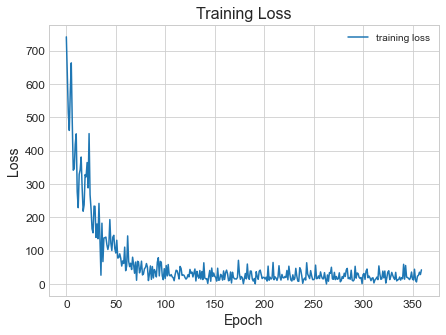

In [23]:
# Visualize the training loss
fig, ax = plt.subplots(figsize = (7, 5))
plt.plot(linear_model.train_losses, label = 'training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss", fontsize = 16)
plt.legend()
plt.show()

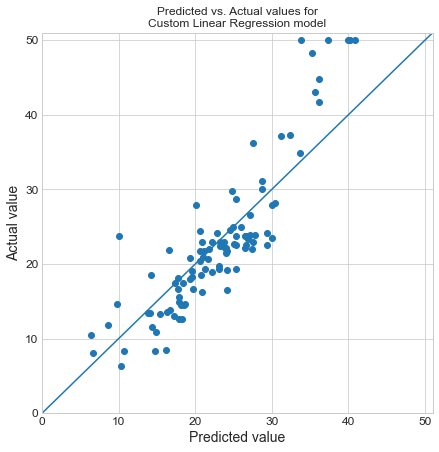

In [24]:
predictions = linear_model.predict(X_test[:100])
labels = y_test[:100]

fig, ax = plt.subplots(figsize = (7, 7))
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nCustom Linear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(predictions, labels)
plt.plot([0, 51], [0, 51]);

In [25]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
data = diabetes.data
target = diabetes.target
features = diabetes.feature_names

In [26]:
data = s.fit_transform(data)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

### Linear Regression

In [28]:
model = Regressor(
                   activation=Linear(),
                   loss=MeanSquaredError(),
                   seed = 1)

In [29]:
linear_model = LinearRegressor(model, SGD(lr=0.01))

linear_model.fit(X_train, y_train, X_test, y_test,
       epochs = 100,
       eval_every = 10);
print()
eval_regression_model(model, X_test, y_test)

Validation loss after 10 epochs is 3378.178
Validation loss after 20 epochs is 3036.622
Validation loss after 30 epochs is 3031.227
Loss increased after epoch 40, 
                            final loss was 3031.227, using the model from epoch 30

Mean absolute error: 41.75

Root mean squared error 55.43


In [30]:
linear_model.model.params

[array([[     -1.6652],
        [    -14.2005],
        [     26.1310],
        [     15.9909],
        [     -4.2445],
        [     -7.8889],
        [    -10.8305],
        [      3.7891],
        [     20.4868],
        [      3.5608]]),
 array([[    150.2898]])]

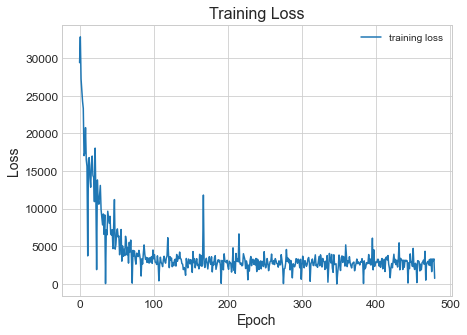

In [31]:
# Visualize the training loss
fig, ax = plt.subplots(figsize = (7, 5))
plt.plot(linear_model.train_losses, label = 'training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss", fontsize = 16)
plt.legend()
plt.show()

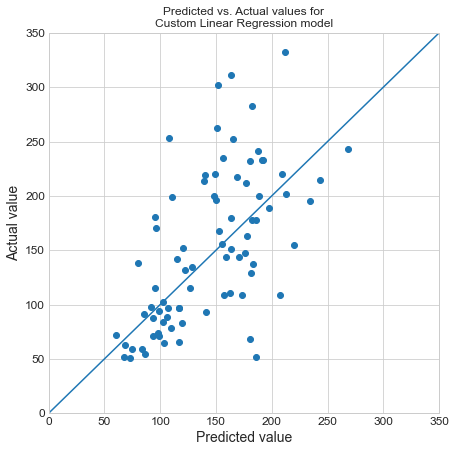

In [32]:
predictions = linear_model.predict(X_test[:80])
labels = y_test[:80]

fig, ax = plt.subplots(figsize = (7, 7))
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nCustom Linear Regression model")
plt.xlim([0, 350])
plt.ylim([0, 350])
plt.scatter(predictions, labels);
plt.plot([0, 350], [0, 350]);